# Plot a 2D projection of attitude and heading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import angle_visualization  # See README for installation instructions, cartopy can be tricky
import sys
sys.path.append("..")
from dissect import plotting_helpers as ph
from dissect import angles as ah

SR = 300  # Hz



# Columns
COL_ACC = ["ax", "ay", "az"]  # accelerometer
COL_GYR = ["gx", "gy", "gz"]  # gyroscope

COL_ACC_G  = ["ax_G", "ay_G", "az_G"]  # gravitational acceleration
COL_ACC_R = ["ax_R", "ay_R", "az_R"]  # non-gravitational acceleration
COL_QUAT = ["qx", "qy", "qz", "qw"]  # quaternion from AHRS filter

In [2]:
import matplotlib
matplotlib.__version__

'3.1.3'

## Data loading

In [3]:
imu = pd.read_pickle("../data_example/example_imu.pickle")
chpt = pd.read_pickle("../data_example/example_chpt.pickle")
time = np.arange(len(imu)) / SR

In [4]:
imu.head(3)

,ax,ay,az,gx,gy,gz,qx,qy,qz,qw,ax_G,ay_G,az_G,ax_R,ay_R,az_R
counter,,,,,,,,,,,,,,,,
703455,-0.437201,0.124428,0.529188,-51.788330,74.554443,15.106201,0.108667,0.330012,-0.038276,0.936920,-0.626708,0.178362,0.758567,0.189507,-0.053934,-0.229379
703456,-0.487250,0.114418,0.469129,-61.309814,59.326172,13.824463,0.110625,0.389789,-0.041640,0.913287,-0.721191,0.169602,0.671654,0.233941,-0.055184,-0.202525
703457,-0.593939,-0.029137,0.406385,-63.079834,46.936035,13.214111,0.329275,0.191478,-0.768666,0.513874,-0.702997,0.044046,0.709828,0.109057,-0.073183,-0.303443


In [5]:
chpt.head(3)

,iloc_start,iloc_end
0,0,198
1,198,244
2,244,300


## Visualization of an example

### Select a segment to plot

In [6]:
seg = 51
iloc_start, iloc_end = chpt.iloc[seg].iloc_start, chpt.iloc[seg].iloc_end 

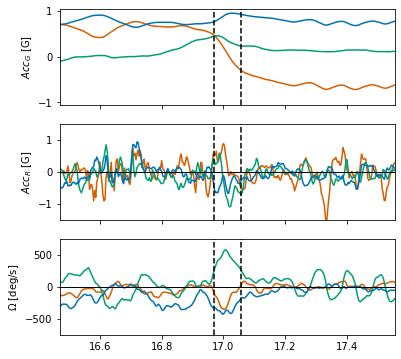

In [7]:
t_start, t_end = time[iloc_start], time[iloc_end]

margin = 150  # margin around the boundaries of the segment
is_to_plot = (np.arange(len(imu)) >= iloc_start - margin) & (np.arange(len(imu)) < iloc_end + margin)


fig, axs = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
for ax in axs:
    ax.set_prop_cycle(ph.RGB_CYCLER)


axs[0].plot(time[is_to_plot], imu[COL_ACC_G][is_to_plot])
axs[1].plot(time[is_to_plot], imu[COL_ACC_R][is_to_plot])
axs[2].plot(time[is_to_plot], imu[COL_GYR][is_to_plot])

    
    
# Cosmetic changes
axs[0].set_ylabel("$Acc_G$ [G]")
axs[0].set_ylim([-1.05, 1.05])

axs[1].set_ylabel("$Acc_R$ [G]")
ph.plot_line_horizontal(0, ax=axs[1], c="k", lw=1)
axs[1].set_ylim([-1.5, 1.5])

axs[2].set_ylabel("$\Omega$ [deg/s]")
ph.plot_line_horizontal(0, ax=axs[2], c="k", lw=1)
axs[2].set_ylim([-750, 750])

axs[2].set_xlim([time[is_to_plot][0], time[is_to_plot][-1]])

for ax in axs:
    ph.plot_line_vertical([t_start, t_end], c="k", linestyle="--", ax=ax)


### Compute 3D heading estimate

In [8]:
imu_window = imu[iloc_start:iloc_end]
acc_G_window = imu_window.loc[:, COL_ACC_G].values  # attitude

quat_window = imu_window.loc[:, COL_QUAT].values
azimuth_3d_window = ah.get_azimuth_estimate(quat_window,  # heading
                                            first_sample_azimuth_zero=True)

### Plot in 3D

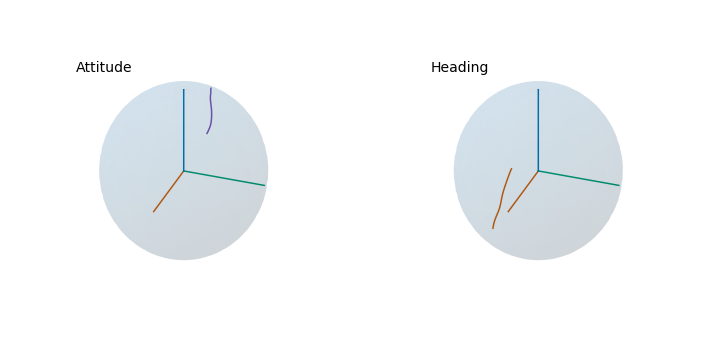

In [9]:
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1, projection="3d")
ax2 = fig.add_subplot(1, 2, 2, projection="3d")

ax1.plot(*acc_G_window.T, c=ph.PURPLE)
ax2.plot(*azimuth_3d_window.T, c=ph.RGB[0])

# Cosmetic
for ax in ax1, ax2:
    ph.plot_sphere(radius=1., steps=30, fc="k", alpha=.1, ax=ax)
    ax.axis("off")
    ph.plot_xyz(ax=ax)
    ax.azim=20
ax1.annotate("Attitude", [.2, .8], xycoords="axes fraction",
             va="bottom", fontsize=14)

ax2.annotate("Heading", [.2, .8], xycoords="axes fraction",
             va="bottom", fontsize=14)


fig.tight_layout()

### 2D projection using LAEA projection

(-13000000.0, 13000000.0)

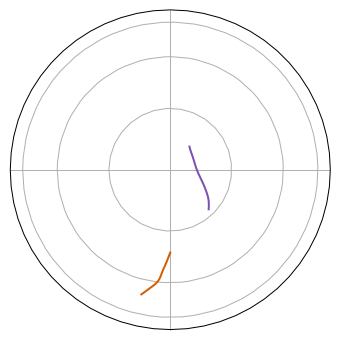

In [10]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=angle_visualization.LAEA)

angle_visualization.plot_projected_euclidean(*acc_G_window.T, ax=ax, c=ph.PURPLE, lw=2)
angle_visualization.plot_projected_euclidean(*azimuth_3d_window.T, ax=ax, c=ph.RGB[0], lw=2)


ax.gridlines(xlocs=[-90, 0, 90, 180, 270], ylocs=[90, 45, 0, -45, -90], linewidth=1)
ax.set_xlim([-1.3e7, 1.3e7])
ax.set_ylim([-1.3e7, 1.3e7])
  

### Same with a color gradient

(-13000000.0, 13000000.0)

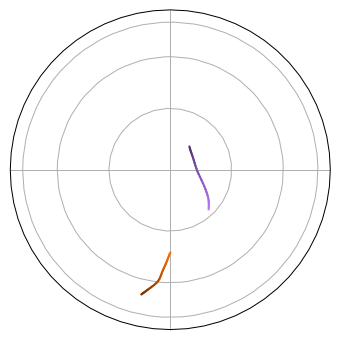

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection=angle_visualization.LAEA)

ph.plot_projected_euclidean_gradient(acc_G_window, ax=ax, cmap="blend:#B878FF,#4A3066", linewidth=2)
ph.plot_projected_euclidean_gradient(azimuth_3d_window, ax=ax, cmap="blend:#FF7000,#723100", linewidth=2)


ax.gridlines(xlocs=[-90, 0, 90, 180, 270], ylocs=[90, 45, 0, -45, -90], linewidth=1)
ax.set_xlim([-1.3e7, 1.3e7])
ax.set_ylim([-1.3e7, 1.3e7])
  